In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.laplace import Laplace
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import  tqdm
import seaborn as sns
import pickle as pkl
from pathlib import Path
DEVICE = torch.device("cuda:3")


In [2]:
torch.cuda.is_available()

True

## Downloading and pre-processing the CIFAR10 data

In [ ]:
DATA_ROOT = Path('../data')

In [20]:
P_VIS = 0.2 # percent of total images per class visible

In [21]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root=DATA_ROOT / 'cifar-10-data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root=DATA_ROOT / 'cifar-10-data', train=False,
                                       download=True, transform=transform)

trainset_len = len(trainset)

CLASSES = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [22]:
DTHRESH = int(P_VIS*len(trainset)) 
trainset.data = trainset.data[:DTHRESH]
trainset.targets = trainset.targets[:DTHRESH]

In [23]:
np.bincount(trainset.targets) / max(np.bincount(trainset.targets))

array([0.97383721, 0.94379845, 1.        , 0.98449612, 0.96802326,
       0.90794574, 0.99806202, 0.96996124, 0.99321705, 0.9505814 ])

In [24]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)


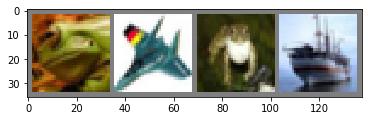

 frog plane  frog  ship


In [25]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % CLASSES[labels[j]] for j in range(4)))

In [26]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(DEVICE)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=3e-4)

## Implementing Thresholdout & Test Routines

In [28]:
class Thresholdout:
    def __init__(self, train, holdout, tolerance=0.01/4, scale_factor=4):
        self.tolerance = tolerance
        
        self.laplace_eps = Laplace(torch.tensor([0.0]), torch.tensor([2*self.tolerance]))
        self.laplace_gamma = Laplace(torch.tensor([0.0]), torch.tensor([4*self.tolerance]))
        self.laplace_eta = Laplace(torch.tensor([0.0]), torch.tensor([8*self.tolerance]))

        self.train = train
        self.holdout = holdout
        
        self.T = 4*tolerance + self.noise(self.laplace_gamma)
        
    def noise(self, dist):
        return dist.sample().item()
        
    def verify_statistic(self, phi):
        """
            - phi(dataset) -> statistic: 
              function returns the average of some statistic
        """
        
        train_val = phi(self.train)
        holdout_val = phi(self.holdout)
                
        delta = abs(train_val - holdout_val)
        
        if delta > self.T + self.noise(self.laplace_eta):
            self.T += self.noise(self.laplace_gamma)
            return holdout_val + self.noise(self.laplace_eps), delta, False
        else:
            return train_val, delta, True

        

In [29]:
tout = Thresholdout(trainloader, testloader)

In [30]:
def test_accuracy(data_loader): # phi
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            images, labels = data[0].to(DEVICE), data[1]
            outputs = net(images).cpu()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return correct / total
    

In [31]:
%time test_accuracy(testloader)

CPU times: user 17.4 s, sys: 1.82 s, total: 19.2 s
Wall time: 5.01 s


0.097

In [32]:
tout.verify_statistic(test_accuracy)

(0.09312035392783582, 0.0029, False)

## Training

In [33]:
experiment = dict()
GLOB_STEP = 0
for epoch in range(30):  # loop over the dataset multiple times

    running_loss = 0.0
    
    for i, data in tqdm(enumerate(trainloader, 0),total=len(trainloader)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        GLOB_STEP += 1
        if i % 1000 == 0 and i:    # print every 2000 mini-batches
            experiment[GLOB_STEP] = tout.verify_statistic(test_accuracy)
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i, running_loss / 1000))
            running_loss = 0.0

print('Finished Training')

[1,  1000] loss: 2.046
[1,  2000] loss: 1.804



[2,  1000] loss: 1.677
[2,  2000] loss: 1.585



[3,  1000] loss: 1.546
[3,  2000] loss: 1.473



[4,  1000] loss: 1.429
[4,  2000] loss: 1.403



[5,  1000] loss: 1.353
[5,  2000] loss: 1.357



[6,  1000] loss: 1.287
[6,  2000] loss: 1.270



[7,  1000] loss: 1.205
[7,  2000] loss: 1.218



[8,  1000] loss: 1.157
[8,  2000] loss: 1.143



[9,  1000] loss: 1.093
[9,  2000] loss: 1.080



[10,  1000] loss: 1.011
[10,  2000] loss: 1.040

Finished Training


In [36]:
experiment

{1001: (0.31736825601849705, 0.0019000000000000128, False),
 2001: (0.3689, 0.00040000000000001146, True),
 3501: (0.399967664720118, 0.017100000000000004, False),
 4501: (0.4326, 0.0121, True),
 6001: (0.4444, 0.018100000000000005, True),
 7001: (0.46167906124554575, 0.027700000000000002, False),
 8501: (0.5124, 0.04049999999999998, True),
 9501: (0.5174, 0.04459999999999997, True),
 11001: (0.47713810348808766, 0.05309999999999998, False),
 12001: (0.48191684897243975, 0.04999999999999999, False),
 13501: (0.5030815732993186, 0.06399999999999995, False),
 14501: (0.49393269665911793, 0.06509999999999999, False),
 16001: (0.4882215152159333, 0.07790000000000002, False),
 17001: (0.5007398826837539, 0.07090000000000007, False),
 18501: (0.5098691794104874, 0.0947, False),
 19501: (0.5255532158289105, 0.09260000000000002, False),
 21001: (0.5217334057934582, 0.10710000000000008, False),
 22001: (0.5399205321237445, 0.10720000000000007, False),
 23501: (0.5141681617982685, 0.135400000000

In [35]:
with open('new-simple-conv-data-p02-30.pkl', 'wb') as fp:
    pkl.dump(experiment, fp)